## Welcome to the **powspechi** tutorial!

This is a journey of fun and discovery which tackles the question: *how similar are the fire balls created in heavy-ion collisions to what we know of the primordial universe?*<br>
Long question... Then how about: *what does the angular power spectrum of heavy-ion collisions look like?*<br>
**¯\\\_(ツ)_/¯**
<br>
The **powspechi** package consists of the main (but not all!) calculations used to extract the angular power spectrum of heavy-ion events at 2.76 TeV energy measured by ALICE in 2010.<br>
In this tutorial we'll go through the main steps of the analysis using some simulated data inspired on the real stuff! Without further ado, let's get started:<br>

In [1]:
import powspechi as pshi # The package itself  
import healpy as hp # Visualizing the event maps
import numpy as np # Classic
import pickle # Load example MC data
import matplotlib.pyplot as plt # Plotting
from matplotlib.ticker import MaxNLocator # Integers in the x-axis
%matplotlib inline
%config InlineBackend.figure_formats=set(['svg'])

In [2]:
# We begin by loading the MC data at hand:
with open('angs1015_etacut09det.dat', 'rb') as f:
    angsMC = pickle.load(f)

# Obs.: If you're running this tutorial on Python 2.7, 
# this cell will raise errors due to pickle incompatibility
# between Python 2.7 and 3.6

In [3]:
# A single command is enough to run the full analysis :D
nside = 16
apsa = pshi.powspec_analysis(
    nside=nside, # Map resolution
    angs=angsMC, # List of event arrays
    etacut=0.9, # Related to theta limitation of `angs`
    detcorr=True, # Assigning weights according to detector's efficiency
    multcorr_norm='avgNl_fexpnorm1015_ns16etacut09.dat', # <N_l> file correcting for multiplicity. Considers pixel weights associated with detector
    multcorr_obs='avgNl_iso1015_ns16etacut09.dat' # <N_l> file correcting only for multiplicity
)

In [4]:
apsa.__dict__.keys() # Attributes

dict_keys(['tmap', 'avcl_obs', 'avcl_norm', 'avcl_normcorr', 'avcl_obscorr'])

We can now check the results of the calculations above. <br>
**♪(┌・。・)┌**<br>
First we take a look at how the sum of all event maps $F^{all}(\theta, \phi)$ looks like:

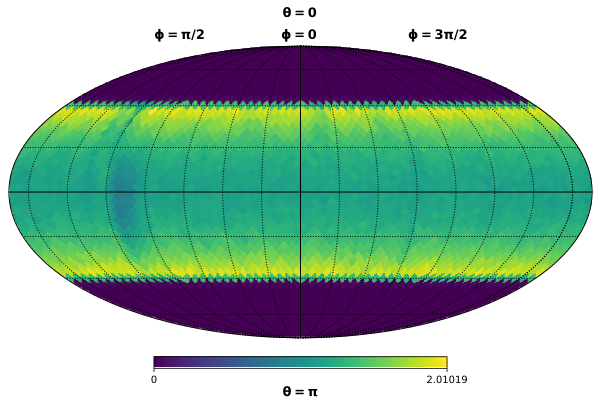

In [5]:
hp.mollview(apsa.tmap, title='')
hp.graticule(22.5, 24., verbose=False)
plt.text(-0.123, 1.2, r'$\mathbf{\theta = 0}$', fontsize=13)
plt.text(-0.123, -1.4, r'$\mathbf{\theta = \pi}$', fontsize=13)
plt.text(-0.133, 1.05, r'$\mathbf{\phi = 0}$', fontsize=13)
plt.text(-1.003, 1.05, r'$\mathbf{\phi = \pi/2}$', fontsize=13)
plt.text(0.737, 1.05, r'$\mathbf{\phi = 3\pi/2}$', fontsize=13)
plt.show()

As promised, the MC data does not produce a uniform map-of-all-events in the azimuthal direction, despite its $\phi$ distributions having different orientations for each event. <br>
Coming up, we check out the spectra - which are basically all the rest of the attributes... **(・ω・)**

In [6]:
# First we create the array of multipoles (l) associated with the chosen resolution:
ls16 = pshi.lns(nside)

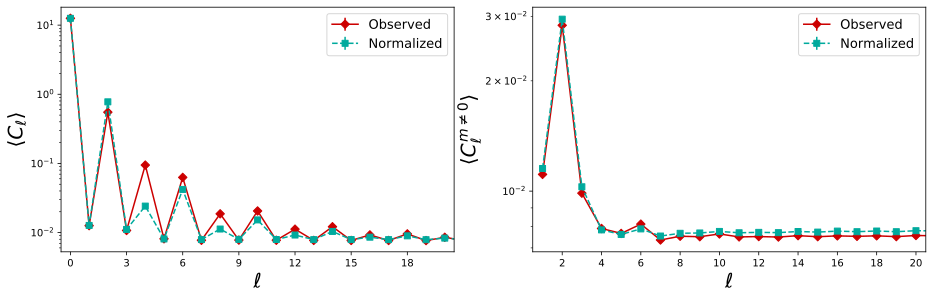

In [7]:
# Now it's plotting time!

c_sims = plt.cm.nipy_spectral(np.linspace(0., 1., 20)) # Loading some colors
klabels = [r'$\langle C_{\ell} \rangle$', r'$\langle C^{m\neq0}_{\ell} \rangle$'] # y-labels for the keys 

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15.5, 4.5)

for key in apsa.avcl_obs.keys():
    ii = 4 - len(key) # So the 'full' spectrum will occupy subplot 0, while 'mdz' occupies 1
    ax[ii].semilogy()
    ax[ii].errorbar(ls16[ii:], apsa.avcl_obs[key][0], apsa.avcl_obs[key][1], fmt='D-', color=c_sims[18], label='Observed')
    ax[ii].errorbar(ls16[ii:], apsa.avcl_norm[key][0], apsa.avcl_norm[key][1], fmt='s--', color=c_sims[7], label='Normalized')
    ax[ii].legend(fontsize=13)
    
    ax[ii].set_xlim(ii-0.5, 20.5)
    ax[ii].xaxis.set_major_locator(MaxNLocator(integer=True)) # Integers to show on x-axis
    ax[ii].set_xlabel(r'$\ell$', fontsize=20)
    ax[ii].set_ylabel(klabels[ii], fontsize=20)
    
plt.show()

Above we can see the results from when data is mapped onto spherical projections, have their power spectra calculated and average taken (*observed*).<br> 
They are compared to the averaged spectrum when the event maps are divided by $F^{all}(\theta, \phi)$ above (*normalized*).<br>

Next we want to check their corrected versions. The sucess of this correction can be verified by comparing the extracted spectra to their analytical calculation, so we shall do that first.<br>
We know the generating function (aside from the simulated detector effect):<br>

$f_{sim}(\theta, \phi) = g_{sim}(\theta)\cdot h_{sim}(\phi)$, where <br>

$g_{sim}(\theta) \propto \cosh((\theta - \pi/2)/2)\cdot ((\theta - \pi/2)^2 + 1)$ **and** $h_{sim}(\phi) = \frac{1}{2\pi} \left[ 1 + 2\sum_{n = 1}^{6} v_n \cos[n(\phi - \Psi_n)] \right]$, <br>

with $v_n$ and $\Psi_n$ the amplitude and phase of $h_{sim}(\phi)$. The former is fixed while the latter varies event-by-event. 

In [8]:
# So of course we know the vn values:
vns_sim = np.array([0.02119, 0.05928, 0.02636, 0.01218, 0.00520, 0.00209])

# Let's calculate!
cls_expq = pshi.cls_calc(
    lsize=11, # We are not comparing beyond this value, so no need to spend computing time on the rest
    alms=pshi.alm_dNdphi, # alm-generating function
    vns=vns_sim, # Coefficients
    psis=np.zeros(len(vns_sim)), # Can be zero because only |a_lm|^2 matters 
    gsim=pshi.ffexp # g_sim(theta) above
)
# So this was the actual function (plus some simple simulation on possible detector effects) that generated 
# the angles loaded in the very beginning.
# Now, we should also calculate the analytical result for g_sim(theta) constant. Why?
# Because normalized maps are divided by g_sim(theta)!

cls_isoq = pshi.cls_calc(
    lsize=11,
    alms=pshi.alm_dNdphi,
    vns=vns_sim,
    psis=np.zeros(len(vns_sim))
)

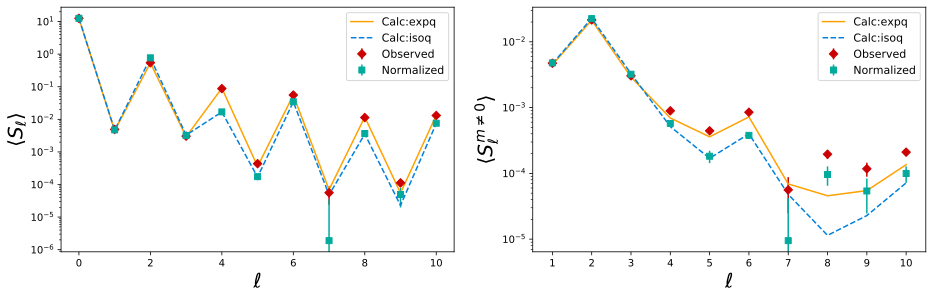

In [9]:
klabels2 = [r'$\langle S_{\ell} \rangle$', r'$\langle S^{m\neq0}_{\ell} \rangle$'] # Corrected spectra are represented by S_l 

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15.5, 4.5)

for key in apsa.avcl_obscorr.keys():
    ii = 4 - len(key) 
    ax[ii].semilogy()
    ax[ii].errorbar(ls16[ii:11], cls_expq[key][:11-ii], fmt='-', color=c_sims[15], label='Calc:expq')
    ax[ii].errorbar(ls16[ii:11], cls_isoq[key][:11-ii], fmt='--', color=c_sims[5], label='Calc:isoq')
    ax[ii].errorbar(ls16[ii:11], apsa.avcl_obscorr[key][0][:11-ii], apsa.avcl_obscorr[key][1][:11-ii], fmt='D', color=c_sims[18], label='Observed')
    ax[ii].errorbar(ls16[ii:11], apsa.avcl_normcorr[key][0][:11-ii], apsa.avcl_normcorr[key][1][:11-ii], fmt='s', color=c_sims[7], label='Normalized')
    ax[ii].legend(fontsize=11)
    
    ax[ii].set_xlim(ii-0.5, 10.5)
    ax[ii].xaxis.set_major_locator(MaxNLocator(integer=True)) # Integers to show on x-axis
    ax[ii].set_xlabel(r'$\ell$', fontsize=20)
    ax[ii].set_ylabel(klabels2[ii], fontsize=20)

plt.show()

Beautiful! ヽ(´▽`)/  

They fit quite nice to the expected (calculated) spectral values... Of course, for a function like $f_{sim}(\theta, \phi)$, when $\ell > 6$ and $m\neq0$, getting the right result becomes trickier.<br>
***
Now, let's have fun with something simpler: we shall create a single event map with $10^7$ particles using the same $f_{sim}(\theta, \phi)$ above and also compare it to the analytically calculated ***cls_expq***.

In [10]:
# Generating particles:

mult = 1000000
qi, qf = 2*np.arctan(np.exp(-np.array([0.9, -0.9]))) # Just getting the theta values for the chosen eta limit...

angs_new = np.column_stack([
    pshi.from_fct(
        fct=pshi.fphi_psi, # h_sim(phi)
        size=mult, # Multiplicity
        xmax=2*np.pi, # Maximum phi value
        vns=vns_sim,
        psis=np.random.uniform(0., 2*np.pi, size=len(vns_sim)) # Psi_n \in [0, 2pi), anything goes
    ),
    pshi.from_fct(
        pshi.fct_sin, # sin(theta)*g_{sim}(theta) -> picking points uniform in a sphere surface!
        mult,
        qi, # Minimum theta value
        qf, # Maximum   "     "
        pshi.ffexp # g_{sim}(theta) passed as argument to `fct_sin`
    )
])

NameError: name 'fct' is not defined

Cool! Let's do it step by step instead of calling ***powspec_analysis***:

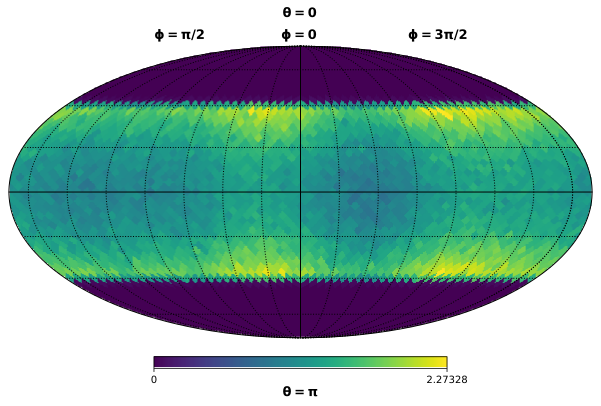

In [91]:
# First a map
mapi_new = pshi.mapping(nside, angs_new)

hp.mollview(mapi_new, title='')
hp.graticule(22.5, 24., verbose=False)
plt.text(-0.123, 1.2, r'$\mathbf{\theta = 0}$', fontsize=13)
plt.text(-0.123, -1.4, r'$\mathbf{\theta = \pi}$', fontsize=13)
plt.text(-0.133, 1.05, r'$\mathbf{\phi = 0}$', fontsize=13)
plt.text(-1.003, 1.05, r'$\mathbf{\phi = \pi/2}$', fontsize=13)
plt.text(0.737, 1.05, r'$\mathbf{\phi = 3\pi/2}$', fontsize=13)
plt.show()

Lighted up on the edges, just like $g_{sim}(\theta)$, with some non-uniformity going on in $\phi$. Just as expected!<br>
Power spectrum time!

In [92]:
cls_new = pshi.maps2cld(mapi_new) # No mysteries here :3

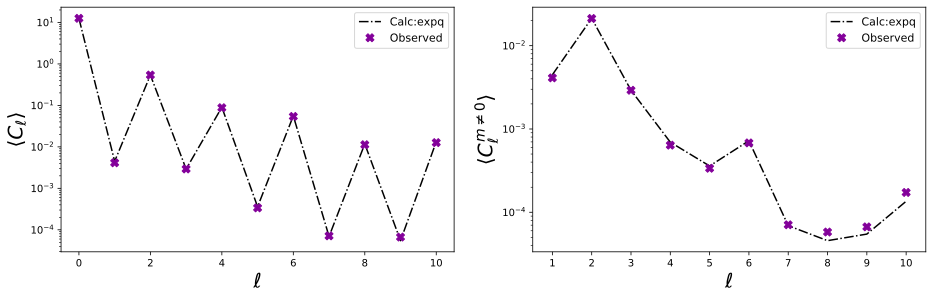

In [94]:
# Plotting in comparison to `cls_expq`:

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15.5, 4.5)

for key in apsa.avcl_obscorr.keys():
    ii = 4 - len(key) 
    ax[ii].semilogy() # Errorbar is unecessary, but I like it because I can change the type of plot for both at the same time just by changing *here*
    ax[ii].errorbar(ls16[ii:11], cls_expq[key][:11-ii], fmt='-.', color=c_sims[0], label='Calc:expq')
    ax[ii].errorbar(ls16[ii:11], cls_new[key][:11-ii], fmt='X', color=c_sims[2], label='Observed', markersize=8.) 
    ax[ii].legend(fontsize=11)
    
    ax[ii].set_xlim(ii-0.5, 10.5)
    ax[ii].xaxis.set_major_locator(MaxNLocator(integer=True)) # Integers to show on x-axis
    ax[ii].set_xlabel(r'$\ell$', fontsize=20)
    ax[ii].set_ylabel(klabels[ii], fontsize=20)

plt.show()

Not bad for a single map! <br>

Unfortunately, we have reached the end of our little tutorial. I truly hope you had some fun doing what I did more than I can count for my PhD. Feel free to experiment with different functions, resolutions, $\eta$ ($\theta$) limitations, etc. Modify this notebook as much as you like, since the original will always be available on the internet. For more details on the analysis itself as well as the true experimental results, check the works mentioned on the documentation of **powspechi**. If you have any questions, just contact me, I'll be glad to help!<br>

Tchau! **(。-ω-)>c[_]**